In [18]:
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import seaborn as sns

In [146]:
def get_data_fromString(filename, regular_mask, data_name=None):
    match = re.search(regular_mask, filename)

    if match:
        data = float(match.group(1))
        print(f"Current data{('(' + data_name + ')') if data_name is not None else ''}:", data)
    else:
        print(f"Data{('(' + data_name + ')') if data_name is not None else ''} is not found")
        try:
            data = float(input(f"Input data{('(' + data_name + ')') if data_name is not None else ''}: "))
            print(f"Current data{('(' + data_name + ')') if data_name is not None else ''}:", data)
        except Exception as e:
            print(e)
            data = 0.1
            print(f"Data set as {data}")
    print()
    return data

def get_data_fromNPZ(filename):
    data = np.load(f'data/{filename}')

    triangularity = get_data_fromString(filename, r"triangularity=([+-]?[0-9]*\.?[0-9]+(?:[eE][+-]?[0-9]+)?)[^0-9]", "triangularity")
    elongation = get_data_fromString(filename, r"elongation=([+-]?[0-9]*\.?[0-9]+(?:[eE][+-]?[0-9]+)?)[^0-9]", "elongation")
    I = get_data_fromString(filename, r"I=([+-]?[0-9]*\.?[0-9]+(?:[eE][+-]?[0-9]+)?)[^0-9]", "I")
    B = get_data_fromString(filename, r"B=([+-]?[0-9]*\.?[0-9]+(?:[eE][+-]?[0-9]+)?)[^0-9]", "B")

    N, M = data["growth"].shape

    data_arr = []
    for i in range(N):
        for j in range(M):
            data_arr.append([data["delta_arr"][i], data["p_multy_arr"][j], data["growth"][i, j]])
    df_ = pd.DataFrame(data_arr, columns=['A', 'P', 'growth'])
    
    plot_diagram(data["delta_arr"], data["p_multy_arr"], data["growth"], data["unstable_mode"], df_, meta={'sigma': triangularity,
                                                                                         'kappa': elongation,
                                                                                         'I': I,
                                                                                         'B': B})
    # , data["A"], data["P"], data["growth"], data["unstable_mode"]
    
    return triangularity, elongation, I, B, df_

def get_data_fromDAT(index=""):
    index_A = pd.read_table(f"data/A{index}.dat", sep=' ', header=None).to_numpy()[:, 0]
    header_P = pd.read_table(f"data/P{index}.dat", sep=' ', header=None).to_numpy()[0]
    
    growth = pd.read_table(f"data/growth{index}.dat", sep=' ', header=None)
    mode = pd.read_table(f"data/unstable_mode{index}.dat", sep=' ', header=None)

    triangularity = get_data_fromString(index, r"triangularity=([+-]?[0-9]*\.?[0-9]+(?:[eE][+-]?[0-9]+)?)[^0-9]", "triangularity")
    elongation = get_data_fromString(index, r"elongation=([+-]?[0-9]*\.?[0-9]+(?:[eE][+-]?[0-9]+)?)[^0-9]", "elongation")
    I = get_data_fromString(index, r"I=([+-]?[0-9]*\.?[0-9]+(?:[eE][+-]?[0-9]+)?)[^0-9]", "I")
    B = get_data_fromString(index, r"B=([+-]?[0-9]*\.?[0-9]+(?:[eE][+-]?[0-9]+)?)[^0-9]", "B")

    N, M = growth.shape
    
    data_arr = []
    for i in range(N):
        for j in range(M):
            data_arr.append([index_A[i], header_P[j], growth.iloc[i, j]])

    df_ = pd.DataFrame(data_arr, columns=['A', 'P', 'growth'])
    
    plot_diagram(index_A, header_P, growth.to_numpy(), mode.to_numpy(), df_, meta={'sigma': triangularity,
                                                                                         'kappa': elongation,
                                                                                         'I': I,
                                                                                         'B': B})
    # , index_A.to_numpy(), header_P.to_numpy(), growth.to_numpy(), mode.to_numpy()
    
    return triangularity, elongation, I, B, df_

def get_isoline(np_growth, df_data, growth_edge):
    zero_mask = abs(np_growth - growth_edge) < np_growth.std() / 4
    plot_data = df_data[zero_mask, :]
    
    plot_x = [plot_data[0, 0]]
    plot_y = [plot_data[0, 1]]
    plot_z = [plot_data[0, 2]]
    n_of_same_x = 1
    for x, y, z in plot_data[1:, :3]:
        if x == plot_x[-1]:
            plot_y[-1] += y
            plot_z[-1] += z
            n_of_same_x += 1
        else:
            plot_y[-1] /= n_of_same_x
            plot_z[-1] /= n_of_same_x
    
            plot_x.append(x)
            plot_y.append(y)
            plot_z.append(z)
            n_of_same_x = 1
    
    plot_y[-1] /= n_of_same_x
    plot_z[-1] /= n_of_same_x

    return plot_x, plot_y, plot_z

def plot_diagram(A_data, P_data, growth_data, mode_data, df, meta):
    growth_edge = 0.1

    plot_x, plot_y, plot_z = get_isoline(df.growth.to_numpy(), df.to_numpy(), growth_edge)
    
    fig, ax = plt.subplots()
    fig.set_figwidth(8)
    fig.set_figheight(7)
    
    pcm = ax.pcolormesh(A_data, P_data, growth_data.T, cmap='winter')
    fig.colorbar(pcm, ax=ax)

    X, Y = np.meshgrid(A_data, P_data)
    # print(X)
    # print(Y)
    for i in range(1, P_data.shape[0]):
        for j in range(1, P_data.shape[0]):
            ax.annotate(f"{mode_data[i, j].astype(int)}",
                     (X.flat[(i - 1) * P_data.shape[0] + j - 1], Y.flat[(i - 1) * P_data.shape[0] + j]), textcoords="offset points",
                     fontsize=10, xytext=(5, 7), alpha=0.6)
    
    # ax.plot(plot_data[:, 0], plot_data[:, 1], marker="+", label='Direct', alpha=0.8)
    # for i, (xi, yi) in enumerate(zip(plot_data[:, 0], plot_data[:, 1])):
    #     ax.annotate(f"{plot_data[i, 2]:.2f}",
    #                  (xi, yi), textcoords="offset points",
    #                  fontsize=8, xytext=(-8, 5))
    
    ax.plot(plot_x, plot_y, marker=".", c="orange")  # , label='Average', alpha=0.8, linewidth=.5
    for i, (xi, yi) in enumerate(zip(plot_x, plot_y)):
        ax.annotate(f"{plot_z[i]:.2f}",
                     (xi, yi), textcoords="offset points",
                     fontsize=8, xytext=(-8, (5 if i%2 else -11)), c="k")
    
    # ax2.legend()
    # ax.set_xlim([df.A.min(), df.A.max()])
    # ax.set_ylim([df.P.min(), df.P.max()])
    
    # ax.grid(which='major', color='#DDDDDD', linewidth=0.9)
    # ax.grid(which='minor', color='#DDDDDD', linestyle=':', linewidth=0.7)
    # ax.minorticks_on()
    # ax.xaxis.set_minor_locator(AutoMinorLocator(10))
    # ax.yaxis.set_minor_locator(AutoMinorLocator(10))
    
    ax.set_title(f"$\\sigma$={meta['sigma']}, $\\kappa$={meta['kappa']}, $I$={meta['I']} $kA$, $B$={meta['B']} $T$\nIsoline by growth: {growth_edge}")
    
    plt.show()

Current data(triangularity): 0.18

Data(elongation) is not found


Input data(elongation):  0.95


Current data(elongation): 0.95

Data(I) is not found


Input data(I):  300


Current data(I): 300.0

Data(B) is not found


Input data(B):  0.7


Current data(B): 0.7



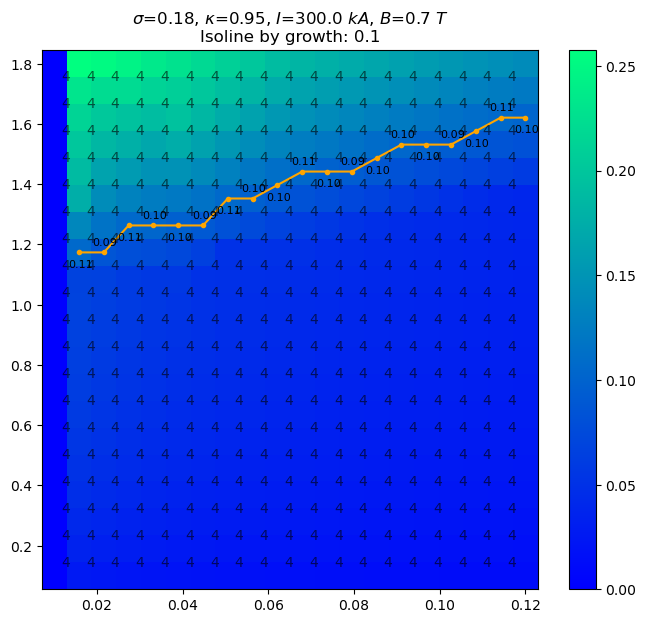

0.18 0.95 300.0 0.7


In [145]:
filename = "output-data_triangularity=1.8e-1.npz"

sigma, kappa, I, B, df = get_data_fromNPZ(filename)  # get_data_fromDAT()  # 

print(sigma, kappa, I, B)

In [63]:
df["sigma"] = sigma
df["kappa"] = kappa
df["I_kA"] = I
df["B_T"] = B

In [64]:
df["mark"] = (df.growth.to_numpy() > growth_edge).astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       400 non-null    float64
 1   P       400 non-null    float64
 2   growth  400 non-null    float64
 3   sigma   400 non-null    float64
 4   kappa   400 non-null    float64
 5   I_kA    400 non-null    float64
 6   B_T     400 non-null    float64
 7   mark    400 non-null    int32  
dtypes: float64(7), int32(1)
memory usage: 23.6 KB


In [65]:
df_train = df.drop("growth", axis=1)
df_train.head(100)

,A,P,sigma,kappa,I_kA,B_T,mark
0,0.045003,0.30000,0.35,1.83,400.0,0.8,0
1,0.045003,0.57368,0.35,1.83,400.0,0.8,0
2,0.045003,0.84737,0.35,1.83,400.0,0.8,0
3,0.045003,1.12105,0.35,1.83,400.0,0.8,0
4,0.045003,1.39474,0.35,1.83,400.0,0.8,0
...,...,...,...,...,...,...,...
95,0.067103,4.40526,0.35,1.83,400.0,0.8,0
96,0.067103,4.67895,0.35,1.83,400.0,0.8,1
97,0.067103,4.95263,0.35,1.83,400.0,0.8,1
98,0.067103,5.22632,0.35,1.83,400.0,0.8,1


In [66]:
index = "3"
df_train.to_csv(f"data/train/train_{index}.csv", index=False)

In [147]:
from scipy.interpolate import RBFInterpolator

xgrid = np.mgrid[-1:1:50j, -1:1:50j]
xflat = xgrid.reshape(2, -1).T
yflat = RBFInterpolator(xobs, yobs)(xflat)
ygrid = yflat.reshape(50, 50)

NameError: name 'RBFInterpolator' is not defined